In [1]:
%xmode minimal
import os
import xarray as xr
import geopandas as gp
import pandas as pd
import numpy as np
import sparse

import hvplot.pandas
import hvplot.xarray
import dask
import cf_xarray

from pynhd import NLDI, WaterData
import intake
import cartopy.crs as ccrs
from shapely.geometry import Polygon

Exception reporting mode: Minimal


os.environ['AWS_PROFILE'] = 'default'
%run ../environment_set_up/Help_AWS_Credentials.ipynb

In [2]:
# open the hytest data intake catalog
hytest_cat = intake.open_catalog("https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/hytest_intake_catalog.yml")
list(hytest_cat)

['conus404-catalog',
 'conus404-drb-eval-tutorial-catalog',
 'nhm-v1.0-daymet-catalog',
 'nhm-v1.1-c404-bc-catalog',
 'nhm-v1.1-gridmet-catalog',
 'trends-and-drivers-catalog',
 'nhm-prms-v1.1-gridmet-format-testing-catalog',
 'nwis-streamflow-usgs-gages-onprem',
 'nwis-streamflow-usgs-gages-osn',
 'nwm21-streamflow-usgs-gages-onprem',
 'nwm21-streamflow-usgs-gages-osn',
 'nwm21-streamflow-cloud',
 'geofabric_v1_1-zip-osn',
 'geofabric_v1_1_POIs_v1_1-osn',
 'geofabric_v1_1_TBtoGFv1_POIs-osn',
 'geofabric_v1_1_nhru_v1_1-osn',
 'geofabric_v1_1_nhru_v1_1_simp-osn',
 'geofabric_v1_1_nsegment_v1_1-osn',
 'gages2_nndar-osn',
 'wbd-zip-osn',
 'huc12-geoparquet-osn',
 'huc12-gpkg-osn',
 'nwm21-scores',
 'lcmap-cloud',
 'rechunking-tutorial-osn',
 'pointsample-tutorial-sites-osn',
 'pointsample-tutorial-output-osn']

In [3]:
# open the conus404 sub-catalog
cat = hytest_cat['conus404-catalog']
list(cat)

['conus404-hourly-onprem',
 'conus404-hourly-cloud',
 'conus404-hourly-osn',
 'conus404-daily-diagnostic-onprem',
 'conus404-daily-diagnostic-cloud',
 'conus404-daily-diagnostic-osn',
 'conus404-daily-onprem',
 'conus404-daily-cloud',
 'conus404-daily-osn',
 'conus404-monthly-onprem',
 'conus404-monthly-cloud',
 'conus404-monthly-osn',
 'conus404-hourly-ba-osn',
 'conus404-daily-ba-osn']

In [4]:
## Select the dataset you want to read into your notebook and preview its metadata
dataset = 'conus404-daily-osn' 
cat[dataset]

conus404-daily-osn:
  args:
    consolidated: true
    storage_options:
      anon: true
      client_kwargs:
        endpoint_url: https://usgs.osn.mghpcc.org/
      requester_pays: false
    urlpath: s3://hytest/conus404/conus404_daily.zarr
  description: CONUS404 40 years of daily values for subset of model output variables
    derived from hourly values. You can work with this data for free in any environment
    (there are no egress fees).
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/subcatalogs


%run ../environment_set_up/Start_Dask_Cluster_Nebari.ipynb
## If this notebook is not being run on Nebari/ESIP, replace the above 
## path name with a helper appropriate to your compute environment.  Examples:
# %run ../environment_set_up/Start_Dask_Cluster_Denali.ipynb
# %run ../environment_set_up/Start_Dask_Cluster_Tallgrass.ipynb
# %run ../environment_set_up/Start_Dask_Cluster_Desktop.ipynb
# %run ../environment_set_up/Start_Dask_Cluster_PangeoCHS.ipynb

In [5]:
ds = cat['conus404-daily-osn'].to_dask()
ds = cat[dataset].to_dask()

C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [6]:
import requests
from IPython.display import HTML

def get_usgs_gage_ids(state_code):
    """
    Fetches USGS gage IDs for a specific state.

    Args:
    - state_code: The two-letter state code (e.g., 'DE' for Delaware).

    Returns:
    - A list of USGS gage IDs for the specified state.
    """
    # USGS NWIS service endpoint for querying station metadata
    url = f'https://waterservices.usgs.gov/nwis/site/?format=rdb&stateCd={state_code}&siteType=ST&siteStatus=active'

    try:
        # Send a GET request to fetch station metadata
        response = requests.get(url)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Split the response text into lines and filter out comments and header lines
            lines = response.text.split('\n')
            data_lines = [line for line in lines if not line.startswith('#')]

            # Extract the site numbers (gage IDs) from the data lines
            gage_ids = [line.split('\t')[1] for line in data_lines if line.strip()]

            return gage_ids
        else:
            print(f"Failed to fetch data. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

# Example usage: Fetch gage IDs for Delaware (state code 'DE')
delaware_gage_ids = get_usgs_gage_ids('IA')

# Generate HTML table
html_table = "<table>"
html_table += "<tr><th>USGS Gage IDs for Iowa</th></tr>"
for gage_id in delaware_gage_ids:
    html_table += f"<tr><td>{gage_id}</td></tr>"
html_table += "</table>"

# Display HTML table
HTML(html_table)

USGS Gage IDs for Iowa
site_no
15s
05387320
05387405
05387440
05387500
05388250
05388310
05389000
05389015


In [7]:
from pynhd import NLDI, WaterData

# Define the USGS gage ID for the location you're interested in
gage_id = '05388310'

# Create an instance of the NLDI class
nldi = NLDI()

# Retrieve the watershed basins (HUC12) associated with the specified USGS gage
del_basins = nldi.get_basins(gage_id)

# Create an instance of the WaterData class for the Watershed Boundary Dataset (WBD12)
wbd12 = WaterData('wbd12')

# Retrieve watershed boundaries (HUC12) based on the geometry of the retrieved basins
huc12_basins = wbd12.bygeom(del_basins.geometry[0])

# Display the retrieved watershed basins
huc12_basins



C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\geopandas\geoseries.py:628: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


,geometry,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,gnis_id,areaacres,areasqkm,states,huc12,name,hutype,humod,tohuc,noncontributingareaacres,noncontributingareasqkm,globalid
0,"MULTIPOLYGON (((-91.63733 43.56164, -91.63563 ...",{07F457AF-2FF7-4B9E-820B-873BAD260DEC},None,None,None,None,2013-01-18T07:08:14Z,None,20345.98,82.34,"IA,MN",070600020501,North Bear Creek,S,NM,070600020503,0,0,{9945D7ED-E29C-11E2-8094-0021280458E6}
1,"MULTIPOLYGON (((-91.40560 43.56939, -91.40487 ...",{5978AE30-2A5B-48E6-A114-8DBA204F17E1},None,None,None,None,2013-01-18T07:08:14Z,None,21121.85,85.48,"IA,MN",070600010402,Lower Winnebago Creek,S,NM,070600010505,0,0,{9944E578-E29C-11E2-8094-0021280458E6}
2,"MULTIPOLYGON (((-91.57115 43.57847, -91.57100 ...",{7CA4A783-9B8F-4CE4-AB11-32312B8D673E},None,None,None,None,2013-01-18T07:08:14Z,None,30624.32,123.93,"IA,MN",070600020502,Waterloo Creek,S,NM,070600020503,0,0,{9945EF0F-E29C-11E2-8094-0021280458E6}
3,"MULTIPOLYGON (((-91.54974 43.47051, -91.54959 ...",{8BD95817-058C-4755-8329-BD52A835101B},None,None,None,None,2013-01-18T07:08:13Z,None,23275.53,94.19,IA,070600020503,Bear Creek,S,TF,070600020602,0,0,{96DC253B-E29C-11E2-8094-0021280458E6}
4,"MULTIPOLYGON (((-91.45751 43.50748, -91.45647 ...",{8E08B60C-0B6B-4F75-8867-EA0CF73A918B},None,None,None,None,2013-01-18T07:08:14Z,None,17460.71,70.66,"IA,MN",070600020605,Clear Creek-Upper Iowa River,S,NM,070600020606,0,0,{99460D1F-E29C-11E2-8094-0021280458E6}
5,"MULTIPOLYGON (((-91.60130 43.72185, -91.59968 ...",{A8AADB05-97B2-44CF-AC70-9F610FB87FA5},None,None,None,None,2013-01-18T07:08:27Z,None,34476.73,139.52,MN,070400080805,Beaver Creek,S,KA,070400080806,0,0,{9F787BDB-E29C-11E2-8094-0021280458E6}
6,"MULTIPOLYGON (((-91.53500 43.60875, -91.53437 ...",{D33F2937-B8A6-49D6-9CA3-24692B56C5C5},None,None,None,None,2013-01-18T07:08:27Z,None,18504.37,74.88,MN,070600010401,Upper Winnebago Creek,S,NM,070600010402,0,0,{9FC4259A-E29C-11E2-8094-0021280458E6}


In [8]:
%%time
# USGS gage 01482100 Delaware River at Del Mem Bridge at Wilmington De
gage_id = '05388310'
nldi = NLDI()
del_basins = nldi.get_basins(gage_id)
huc12_basins = WaterData('wbd12').bygeom(del_basins.geometry[0])

CPU times: total: 1.84 s
Wall time: 1.96 s


C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\geopandas\geoseries.py:628: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


In [9]:
regions_df = huc12_basins
region_name = 'name'

<Axes: >

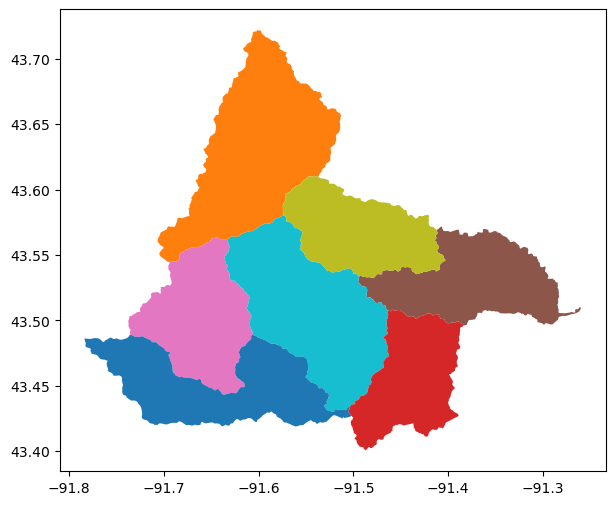

In [10]:
regions_df.plot(column=region_name, figsize=(12,6))

In [11]:
crs_orig = f'EPSG:{regions_df.crs.to_epsg()}'
crs_orig

'EPSG:4326'

In [12]:
x = 'x'  # projected x coordinate name
y = 'y'  # projected y coordinate name

In [13]:
crs_info = ds.crs
xx = ds.x.values
yy = ds.y.values
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = ccrs.LambertConformal(globe=globe,
                            central_longitude=crs_info.longitude_of_central_meridian, 
                            central_latitude=crs_info.latitude_of_projection_origin,
                            standard_parallels=crs_info.standard_parallel)

In [14]:
lcc_wkt = lcc.to_wkt()

In [15]:
regions_df = regions_df.to_crs(lcc_wkt)

In [16]:
bbox = tuple(regions_df.total_bounds)
bbox

(486228.32524614694, 489495.969212784, 527625.9636697206, 523995.2564236253)

In [17]:
ds = ds.sel(x=slice(bbox[0],bbox[2]), y=slice(bbox[1],bbox[3]))

In [18]:
var = 'T2'  # 2m Temp
var = 'ACRAINLSM' # precip`

In [19]:
grid = ds[[var]].drop(['time', 'lon', 'lat', var]).reset_coords().load()
grid

<xarray.Dataset>
Dimensions:  (x: 10, y: 8)
Coordinates:
  * x        (x) float64 4.88e+05 4.92e+05 4.96e+05 ... 5.2e+05 5.24e+05
  * y        (y) float64 4.92e+05 4.96e+05 5e+05 ... 5.12e+05 5.16e+05 5.2e+05
Data variables:
    *empty*
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

In [20]:
grid = grid.cf.add_bounds([x, y])

In [21]:
points = grid.stack(point=(y,x))
points

<xarray.Dataset>
Dimensions:   (bounds: 2, point: 80)
Coordinates:
    x_bounds  (bounds, point) float64 4.86e+05 4.9e+05 ... 5.22e+05 5.26e+05
    y_bounds  (bounds, point) float64 4.9e+05 4.9e+05 ... 5.22e+05 5.22e+05
  * point     (point) object MultiIndex
  * y         (point) float64 4.92e+05 4.92e+05 4.92e+05 ... 5.2e+05 5.2e+05
  * x         (point) float64 4.88e+05 4.92e+05 4.96e+05 ... 5.2e+05 5.24e+05
Dimensions without coordinates: bounds
Data variables:
    *empty*
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

In [22]:
def bounds_to_poly(x_bounds, y_bounds):
    return Polygon([
        (x_bounds[0], y_bounds[0]),
        (x_bounds[0], y_bounds[1]),
        (x_bounds[1], y_bounds[1]),
        (x_bounds[1], y_bounds[0])
    ])

In [23]:
%%time
boxes = xr.apply_ufunc(
    bounds_to_poly,
    points.x_bounds,
    points.y_bounds,
    input_core_dims=[("bounds",),  ("bounds",)],
    output_dtypes=[np.dtype('O')],
    vectorize=True
)

CPU times: total: 15.6 ms
Wall time: 8 ms


In [24]:
grid_df= gp.GeoDataFrame(
    data={"geometry": boxes.values, "y": boxes[y], "x": boxes[x]},
    index=boxes.indexes["point"],
    crs=lcc_wkt
)

In [25]:
crs_area = "EPSG:6931"

regions_df = regions_df.to_crs(crs_area)
grid_df = grid_df.to_crs(crs_area)

grid_df.crs

<Projected CRS: EPSG:6931>
Name: WGS 84 / NSIDC EASE-Grid 2.0 North
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere.
- bounds: (-180.0, 0.0, 180.0, 90.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 North
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
overlay = grid_df.overlay(regions_df, keep_geom_type=True)

In [27]:
sparsity = len(overlay) / (len(grid_df) * len(regions_df))
sparsity

0.16428571428571428

In [28]:
overlay.geometry.area.groupby(overlay[region_name]).sum().nlargest(10)/1e6  # km2
regions_df.geometry.area.groupby(regions_df[region_name]).sum().nlargest(10)

name
Beaver Creek                    1.395223e+08
Waterloo Creek                  1.239324e+08
Bear Creek                      9.419274e+07
Lower Winnebago Creek           8.547713e+07
North Bear Creek                8.233731e+07
Upper Winnebago Creek           7.488454e+07
Clear Creek-Upper Iowa River    7.066092e+07
dtype: float64

In [29]:
grid_cell_fraction = overlay.geometry.area.groupby(overlay[region_name]).transform(lambda x: x / x.sum())
grid_cell_fraction
grid_cell_fraction.groupby(overlay[region_name]).sum()

name
Bear Creek                      1.0
Beaver Creek                    1.0
Clear Creek-Upper Iowa River    1.0
Lower Winnebago Creek           1.0
North Bear Creek                1.0
Upper Winnebago Creek           1.0
Waterloo Creek                  1.0
dtype: float64

In [30]:
multi_index = overlay.set_index([y, x, region_name]).index
df_weights = pd.DataFrame({"weights": grid_cell_fraction.values}, index=multi_index)
df_weights

weights
y        x        name                           
492000.0 488000.0 Bear Creek             0.004443
         492000.0 Bear Creek             0.124515
         496000.0 Bear Creek             0.139973
         500000.0 Bear Creek             0.111558
         504000.0 Bear Creek             0.108970
...                                           ...
508000.0 512000.0 Upper Winnebago Creek  0.206377
         516000.0 Upper Winnebago Creek  0.049329
512000.0 504000.0 Upper Winnebago Creek  0.083774
         508000.0 Upper Winnebago Creek  0.041701
         512000.0 Upper Winnebago Creek  0.006782

[92 rows x 1 columns]

In [31]:
ds_weights = xr.Dataset(df_weights)

In [32]:
weights_sparse = ds_weights.unstack(sparse=True, fill_value=0.).weights

In [33]:
def apply_weights_matmul_sparse(weights, data):

    assert isinstance(weights, sparse.SparseArray)
    assert isinstance(data, np.ndarray)
    data = sparse.COO.from_numpy(data)
    data_shape = data.shape
    # k = nlat * nlon
    n, k = data_shape[0], data_shape[1] * data_shape[2]
    data = data.reshape((n, k))
    weights_shape = weights.shape
    k_, m = weights_shape[0] * weights_shape[1], weights_shape[2]
    assert k == k_
    weights_data = weights.reshape((k, m))

    regridded = sparse.matmul(data, weights_data)
    assert regridded.shape == (n, m)
    return regridded.todense()

In [34]:
## %%time
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    var_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        weights_sparse,
        ds[var],
        join="left",
        input_core_dims=[[y, x, region_name], [y, x]],
        output_core_dims=[[region_name]],
        dask="parallelized",
        dask_gufunc_kwargs=dict(meta=[np.ndarray((0,))])
    )
    

var_regridded.compute()

C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\sparse\_common.py:209: RuntimeWarning: Nan will not be propagated in matrix multiplication
  warnings.warn("Nan will not be propagated in matrix multiplication", RuntimeWarning, stacklevel=1)


<xarray.DataArray (time: 15707, name: 7)>
array([[3.09316794e+01, 3.58164931e+01, 4.30846135e+01, ...,
        3.15885873e+01, 4.70138788e+01, 3.96097946e+01],
       [3.35990712e-02, 6.18667555e-03, 8.91888635e-02, ...,
        2.62551990e-02, 4.47704862e-02, 2.95050855e-02],
       [5.82871191e-01, 1.64141831e-01, 2.19289867e-02, ...,
        1.64814902e-01, 8.89233394e-02, 2.23396559e-02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.60417237e-08, 0.00000000e+00, 2.65834723e-07, ...,
        0.00000000e+00, 0.00000000e+00, 5.42869186e-08],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * name     (name) object 'Bear Creek' 'Beaver Creek' ... 'Waterloo Creek'
  * time     (time) datetime64[ns] 1979-10-01 1979-10-02 ... 2022-10-01

In [50]:
ds_var = var_regridded.sel(name=['Bear Creek', 'Beaver Creek']).resample(time="D").mean().to_dataset(region_name)

# Minutely frequencies:

#     'T' or 'min': Minute
#     '5T' or '5min': 5 minutes
#     '15T' or '15min': 15 minutes
#     '30T' or '30min': 30 minutes

# Hourly frequencies:

#     'H' or 'hour': Hour
#     '2H' or '2hour': 2 hours
#     '3H' or '3hour': 3 hours
#     '6H' or '6hour': 6 hours

# Daily frequencies:

#     'D' or 'day': Day
#     '2D' or '2day': 2 days
#     '3D' or '3day': 3 days
#     'W' or 'week': Weekly

# Monthly frequencies:

#     'M' or 'month': Month end
#     'MS' or 'month_start': Month start

# Yearly frequencies:

#     'Y' or 'year': Year end
#     'YS' or 'year_start': Year star

In [44]:
ds_var.hvplot(x='time', grid=True, frame_width=1000)

C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\sparse\_common.py:209: RuntimeWarning: Nan will not be propagated in matrix multiplication
  warnings.warn("Nan will not be propagated in matrix multiplication", RuntimeWarning, stacklevel=1)


:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [45]:
# Acummulated Annual
ds_var_Annual = var_regridded.sel(name=['Bear Creek', 'Beaver Creek']).resample(time="AS").sum().to_dataset(region_name)
ds_var_Annual.hvplot(x='time', grid=True, frame_width=1000)


C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\sparse\_common.py:209: RuntimeWarning: Nan will not be propagated in matrix multiplication
  warnings.warn("Nan will not be propagated in matrix multiplication", RuntimeWarning, stacklevel=1)


:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [46]:
df_mean = var_regridded.to_pandas().mean()
df_mean.name = var
df_mean = pd.DataFrame(df_mean).reset_index()
merged = pd.merge(regions_df, df_mean)

C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\sparse\_common.py:209: RuntimeWarning: Nan will not be propagated in matrix multiplication
  warnings.warn("Nan will not be propagated in matrix multiplication", RuntimeWarning, stacklevel=1)


In [47]:
crs_geo = 'EPSG:4326'

In [48]:
merged_geo = merged.to_crs(crs_geo)

In [49]:
merged_geo.hvplot(c=var, geo=True, cmap='viridis_r', frame_width=600, tiles='OpenTopoMap', 
               title='CONUS404', alpha=0.5)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (ACRAINLSM)